In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts

PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

## .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

### Input

In [2]:
from structure_tools.vcf_geno_tools import simple_read_vcf

vcf_file= 'data_val_g30d0.40s10.vcf'

genotype, summary, info_save= simple_read_vcf(vcf_file,row_info= 5,header_info= 9,phased= False)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))



Number of markers: 18881
Number of individuals: 110


In [3]:
summary.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
0,1,4612,1,A,T,.,PASS,.,GT:AD:DP
1,1,5621,2,A,T,.,PASS,.,GT:AD:DP
2,1,7419,3,A,T,.,PASS,.,GT:AD:DP
3,1,7437,4,A,T,.,PASS,.,GT:AD:DP
4,1,15339,5,A,T,.,PASS,.,GT:AD:DP


### Global variation

Perform PCA across data set.

Perform Mean shift clustering to attempt to extract genetically coherent groups of accessions.

These will later be used for supervised analysis.

In [8]:
n_comp= 3

In [9]:
from structure_tools.Tutorial_subplots import plot_global_pca

## Perform PCA
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(genotype)

In [10]:
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=25)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}


In [11]:
###
plot_global_pca(feats,label_select,PCA_color_ref,title= 'global_pca',height= 500,width= 950)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [12]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 150
Steps= 20

Windows, Out= geno_window_split(genotype,
                                summary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 938


### I. Local variation sample

Visualize genetic structure at local windows using PCA. Plot colors will correspond to the Mean shift clustering above. 

Use the list `plot_who` to plot only accessions from specific groups.

Use the list `shade` to lower the opacity of samples from specific groups.

In [13]:
## a look at local windows
from structure_tools.Tutorial_subplots import window_sample_plot

windows_pick= 5
Chr= 1

plot_who= [2,3,4]
shade= [0,1]

window_sample_plot(Windows,
                   label_select,
                   PCA_color_ref,
                   plot_who= plot_who,
                   shade= shade,
                   Chr= 1,
                   windows_pick= windows_pick,
                   height= 1500,width= 1000)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]



## II. Variation across windows.

>*i. Chose a range of windows, or a number of windows to be sampled randomly.*

>*ii. Perform PCA, AMOVA and allele frequency extraction at each window*

Analyses can be performed in either a supervised or an unsupervised manner.
For supervised analyses, use the labels from the Meanshift analysis above to chose reference labels. If the argument `include_who` is provided (list), analyses will be perform using only samples from the groups identified in that list.

>*i. Analyse AMOVA density and distribution across windows.*

>*ii. Analyse genetic distance between reference or unsupervised groups at selected windows.*

>*iii. Analyze principal component analysis projection along 1st PC across windows selected.*


### **i.** Window analysis

In [40]:
from structure_tools.Modules_tools import return_fsts2
from structure_tools.vcf_geno_tools import window_analysis, window_fst_sup

ref_labels= [2,3,4]
include_who= [2,3]

PC_sel= 1

Windows_range_fst= [200,750]

Fst_window= window_fst_sup(Windows,
                         ref_labels,
                         labels1,
                         Chr= 1,
                         ncomp= 4,
                        range_sample= Windows_range_fst)

include_who= [3,4]
Windows_range_pca= [550,700]


Frequencies, sim_fst, Results, Construct, pc_density, pc_coords, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 labels1,
                                                                                 Chr= 1,
                                                                                 ncomp= 4,
                                                                                 amova= True,
                                                                                 supervised= True,
                                                                                 include_who= include_who,
                                                                                 range_sample= Windows_range_pca,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20,
                                                                                 quantile= .2,
                                                                                 centre_d= True,
                                                                                 PC_sel= PC_sel - 1)


counting: 0.6465211401001593, Ngps: 2


In [41]:
Results['info'].head()

,chrom,window,AMOVA,Ngps
0,1.0,56362421.0,0.564743,2.0
1,1.0,56508053.0,0.527075,2.0
2,1.0,56721384.0,0.522781,2.0
3,1.0,56819796.0,0.471317,2.0
4,1.0,56930193.0,0.478666,2.0


### AMOVA

- Density plot

In [25]:
AMOVA_winds= Results['info'].AMOVA

X_plot = np.linspace(0, 1, 100)

freq_kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(AMOVA_winds).reshape(-1,1))

log_dens = freq_kde.score_samples(X_plot.reshape(-1,1))

fig_AMOVA_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= '',
                            line=dict(color='blue', width=2))]
##

layout= go.Layout(
    title= 'AMOVA across windows - density',
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'AMOVA'
    )
)

fig = go.Figure(data=fig_AMOVA_dens, layout= layout)

iplot(fig)

- AMOVA *x* windows

In [26]:
fig_genAMOVA= [go.Scatter(
    x= list(range(Windows_range_pca[0],Windows_range_pca[1])),
    y= AMOVA_winds
)]

layout_genam= go.Layout(
    title= 'AMOVA along chrom.',
    yaxis= dict(
        range= [0,2]
    )
)

fig = go.Figure(data=fig_genAMOVA, layout= layout_genam)
fig['layout'].update(height= 400,width= 900)

iplot(fig)

### **ii.** Fst across data sets

- Density plot

In [27]:
iplot(fst_fig)

- Fst *x* windows

In [28]:
from structure_tools.Tutorial_subplots import fst_window_plot



fst_window_plot(Fst_window,ref_labels,sort= False,window_range= Windows_range_fst,y_range= [0,.5],height= 400,width= 900)

### **iii.** PC sample distribution across data sets queried.

In [42]:
from structure_tools.Tutorial_subplots import PC_analysis_plot

labels_code= labels1

if include_who:
    labels_code= [x for x in labels_code if x in include_who]

## plot_choices: ['coords','density']
fig= PC_analysis_plot(pc_density,pc_coords,labels_code,PCA_color_ref,range_windows= Windows_range_pca,
                 plot_choice= 'coords',height= 400,width= 1000,y_range= [-7,12],qtl= .99,PC_sel= PC_sel)

iplot(fig)

### iv. Analysis of a single population.

Considerations for simulation approaches.

In [43]:
dict_coords= {}
Windows_range_pca= [400,550]


for access in ref_labels:
    include_who= [access]


    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_sel - 1)
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [44]:
for access in dict_coords.keys():

    fig= PC_analysis_plot(dict_coords[access]['dens'],dict_coords[access]['coords'],dict_coords[access]['labs'],PCA_color_ref,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-7,12],qtl= .99,PC_sel= PC_sel)
    
    iplot(fig)


150
(150, 2)


150
(150, 2)


150
(150, 2)


### One population across components


In [46]:
dict_coords= {}
Windows_range_pca= [400,650]

group_list= [2,2,2]
PC_selection= [1,2,3]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     labels1,
                                                                                     Chr= 1,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    labels_code_s= labels1

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [47]:
for access in range(len(group_list)):
    include_who= [group_list[access]]
    

    fig= PC_analysis_plot(dict_coords[access]['dens'],dict_coords[access]['coords'],dict_coords[access]['labs'],PCA_color_ref,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-9,12],qtl= .99,PC_sel= PC_selection[access])
    
    iplot(fig)


250
(250, 2)


250
(250, 2)


250
(250, 2)


### Sound from amp

We will use the standard deviation of a single population across a given component as the amplitude of a audio signal.

First select the group, PC and range of local windows to use. We run the `window_analysis` function to extract centred PCA coordinates.



In [48]:
from structure_tools.vcf_geno_tools import get_sound_coords

group= 2
PC_select= 1
Windows_range_music= [400,650]


Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 labels1,
                                                                                 Chr= 1,
                                                                                 ncomp= 4,
                                                                                 amova= False,
                                                                                 supervised= True,
                                                                                 include_who= [group],
                                                                                 range_sample= Windows_range_music,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20,
                                                                                 quantile= .2,
                                                                                 centre_d= True,
                                                                                 PC_sel= PC_select - 1)


#####
#####
#####


In the next block we make use of the PCA coordinates extracted to calculate standard deviation at each window. Coordinates have been centered so that the mean is 0, so we use the distance between a normal confidence interval to extract magnitude. 

We extract magnitude across windows. We select sample Rate of the audio file, and the length of the file, in seconds. A function of amplitude by time is interpolated from the magnitude of confidence intervals. Frequency determines the frequency of the signal produced. The `get_sound_coords` function produces a `.wav` file.

In [51]:
qtl= 0.95

sampleRate = 44100
frequency = 1600
length = 10

fig_test= get_sound_coords(pc_coords_s,sampleRate= sampleRate,
                                frequency= frequency,
                                length= length,
                                group= group,
                                PC_select= PC_select)


fig_test['layout'].update(height= 400,width= 900)
iplot(fig_test)

## KDE classification across windows

### Supervised classification across windows.

Perform supervised classification of samples across local genomic windows using Kernel Density Estimation.

The function `KDE_windows` allows for an outlier threshold and a *p*-value comparison threshold for ambiguous classifications.

In [198]:

from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, return_ideogram

## Use result of MS classification.
ref_labels= [2,3,4]
kde_class_labels= labels1

Comparison_threshold= 4
Outlier_threshold= 1e-5
n_comps= 4

color_ref= ['red','yellow','blue','black','orange','purple','green','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

ideo_kde,chromosome_list, ID, var_comp_store= KDE_windows(Windows,
                                                          kde_class_labels,
                                                          ref_labels,Out,
                                                          colors= 'alt',
                                                          n_comps=n_comps,
                                                          alt_col= color_ref,
                                                          Comparison_threshold= Comparison_threshold,
                                                          Outlier_threshold= Outlier_threshold)


adding ideograms...


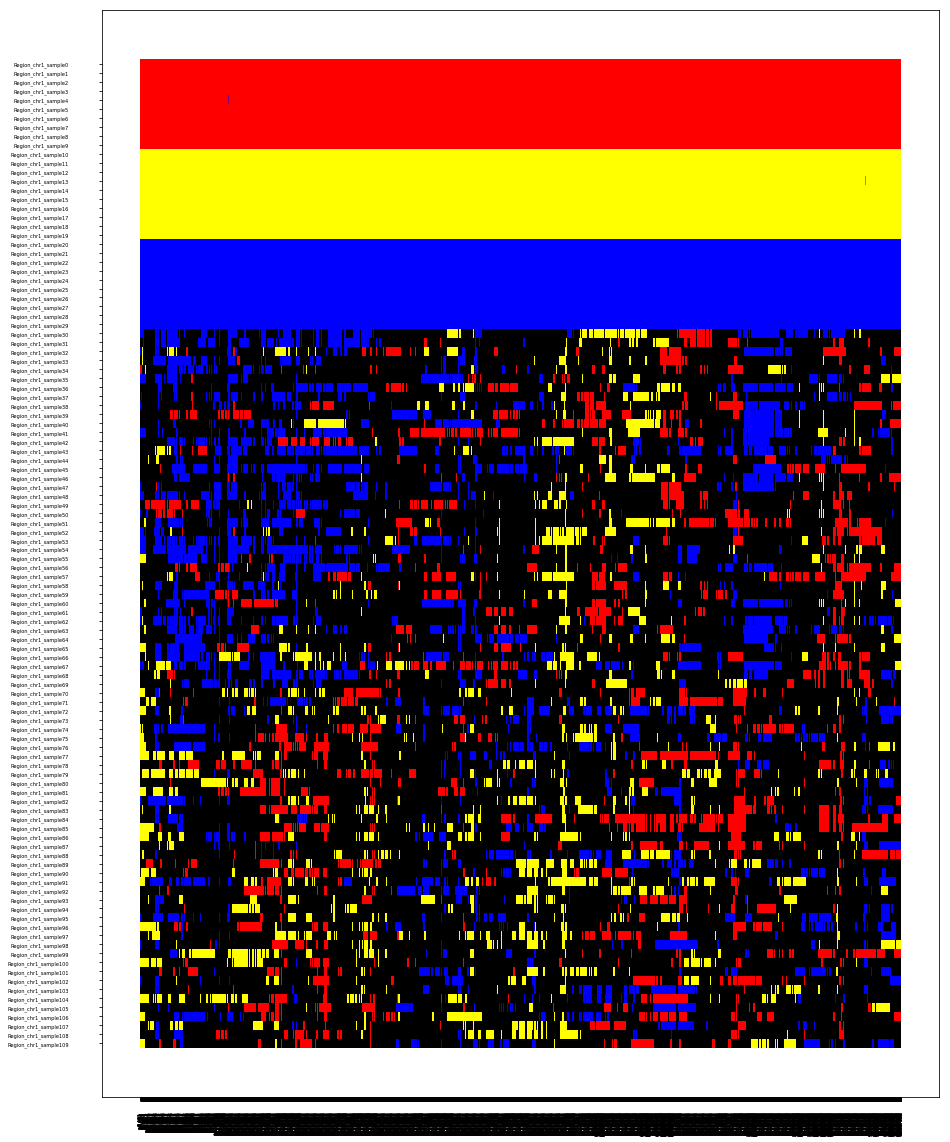

In [70]:
Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 20,width= 15)